<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/03_MLP_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicción y Evaluación de un modelo MLP

#### **Importación de Datos**

In [ ]:
import requests
import pandas as pd
import numpy as np
import sys, os, math, typing as t
import warnings
import time

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from io import BytesIO
from dataclasses import dataclass
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from tensorflow import keras
from tensorflow.keras import layers, regularizers, mixed_precision

plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True
})

warnings.filterwarnings('ignore')

tf.keras.utils.set_random_seed(42)
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
# Importar datos
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.set_index("datetime")

# Validaciones mínimas
expected_cols = {"temperature","humidity","general_diffuse_flows","zone_1"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas en el dataset: {missing}. "
                     f"Columnas disponibles: {df.columns.tolist()}")

print("\nFrecuencia aproximada:", (df.index.to_series().diff().mode().iloc[0]))
print("Filas totales:", len(df))


Frecuencia aproximada: 0 days 00:10:00
Filas totales: 52416


#### Definición de Funciones y Partición de los datos

In [ ]:
from typing import Optional, Dict

def temporal_split(df: pd.DataFrame, train_size=0.7, val_size=0.2):
    """Split temporal 70/20/10 por defecto."""
    n = len(df)
    n_train = int(n * train_size)
    n_val = int(n * val_size)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test

def make_windows(
    data: pd.DataFrame,
    target_col: str,
    feature_cols: t.List[str],
    history: int = 1008,   # 7 días de 10-min
    target_shift: int = 1   # 1 paso adelante
):
    """Crea X, y con ventana deslizante. X tiene forma (N, history, F).
    Para modelos tipo sklearn, se devuelve además X2 (aplanado)."""
    feats = data[feature_cols].values
    target = data[target_col].values
    X, y = [], []
    for i in range(len(data) - history - target_shift + 1):
        X.append(feats[i:i+history])
        y.append(target[i+history+target_shift-1])
    X = np.array(X)
    y = np.array(y)
    # Aplanado para modelos de tabular (árboles, etc.)
    ns, h, f = X.shape
    X2 = X.reshape((ns, h*f))
    return X, X2, y

def smape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0

def wape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps)) * 100.0

@dataclass
class Scalers:
    X: Optional[StandardScaler] = None
    y: Optional[StandardScaler] = None

def fit_scalers(train_df: pd.DataFrame, feature_cols: t.List[str], target_col: str) -> Scalers:
    sx = StandardScaler()
    sy = StandardScaler()
    sx.fit(train_df[feature_cols])
    sy.fit(train_df[[target_col]])
    return Scalers(X=sx, y=sy)

def apply_scalers(df: pd.DataFrame, scalers: Scalers, feature_cols: t.List[str], target_col: str):
    out = df.copy()
    out[feature_cols] = scalers.X.transform(out[feature_cols])
    out[target_col]  = scalers.y.transform(out[[target_col]])
    return out

def inverse_target(y: np.ndarray, scalers: Scalers) -> np.ndarray:
    return scalers.y.inverse_transform(y.reshape(-1,1)).ravel()

def plot_segment(idx, y_true, y_pred, title="Predicción (tramo)", target_name="target"):
    plt.figure(figsize=(12,4))
    plt.plot(idx, y_true, label="Real", linewidth=2)
    plt.plot(idx, y_pred, label="Pred", linewidth=2)
    plt.title(title)
    plt.xlabel("Tiempo"); plt.ylabel(target_name); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
TARGET_COL = "zone_1"  # consumo a pronosticar
EXOG_COLS = ["temperature", "humidity", "general_diffuse_flows"]  # exógenas priorizadas

# Ordenar columnas por claridad (target al final)
cols = EXOG_COLS + [TARGET_COL]
df2 = df[cols].copy().astype("float32")

# Splits temporales base (para val/test)
train_df_full, val_df, test_df = temporal_split(df2, train_size=0.7, val_size=0.2)
print({s: len(x) for s,x in [('train_full',train_df_full),('val',val_df),('test',test_df)]})


# Entrenar con los últimos 45 días
POINTS_PER_DAY = 24 * 6           # 10 min = 6 puntos por hora = 144 por día
TRAIN_DAYS = 45
WINDOW_TRAIN_POINTS = TRAIN_DAYS * POINTS_PER_DAY  # 45 * 144 = 6480

HISTORY_WINDOW = 7 * POINTS_PER_DAY   # 7 días = 1008 pasos
SHIFT_ONE_STEP = 1                    # +10 min

# Tomamos exactamente los últimos 45 días como training
train_df = train_df_full.tail(WINDOW_TRAIN_POINTS)

print(
    "train_df (últimos 45 días) =",
    train_df.index.min(), "→", train_df.index.max(),
    "| filas:", len(train_df)
)


# Escalado Z-score (stats SOLO del train de 45 días)
scalers = fit_scalers(train_df, EXOG_COLS, TARGET_COL)
train_n = apply_scalers(train_df, scalers, EXOG_COLS, TARGET_COL)
val_n   = apply_scalers(val_df,   scalers, EXOG_COLS, TARGET_COL)
test_n  = apply_scalers(test_df,  scalers, EXOG_COLS, TARGET_COL)

# Ventanas one-step (history=1008, shift=1)
Xtr, Xtr2, ytr = make_windows(
    train_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xva, Xva2, yva = make_windows(
    val_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xte, Xte2, yte = make_windows(
    test_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)

print("Shapes →",
      "Xtr2:", Xtr2.shape, "ytr:", ytr.shape, "|",
      "Xva2:", Xva2.shape, "yva:", yva.shape, "|",
      "Xte2:", Xte2.shape, "yte:", yte.shape)

# Validación rápida
assert Xtr2.shape[0] >= 1, "No hay suficientes filas en los últimos 45 días para formar al menos 1 ventana."


{'train_full': 36691, 'val': 10483, 'test': 5242}
train_df (últimos 45 días) = 2017-07-29 19:10:00 → 2017-09-12 19:00:00 | filas: 6480
Shapes → Xtr2: (5472, 4032) ytr: (5472,) | Xva2: (9475, 4032) yva: (9475,) | Xte2: (4234, 4032) yte: (4234,)


#### **Entrenamiento**

In [ ]:
# ENTRENAMIENTO — MLP (Dense) sobre ventanas aplanadas
# - Un MLP "multi-step dense" consume toda la ventana (history*features) ya aplanada.
# - Captura interacciones no lineales entre lags y exógenas sin imponer inductiva secuencial.
# - Regularizamos (Dropout + L2) y usamos EarlyStopping/ReduceLROnPlateau para estabilidad.

# ---- Tipos livianos para acelerar (CPU o GPU)
Xtr2 = Xtr2.astype("float32"); ytr = ytr.astype("float32")
Xva2 = Xva2.astype("float32"); yva = yva.astype("float32")
Xte2 = Xte2.astype("float32"); yte = yte.astype("float32")


input_dim = Xtr2.shape[1]  # = HISTORY_WINDOW * (len(EXOG_COLS)+1)

def build_mlp(input_dim: int) -> keras.Model:
    # Notas de diseño:
    # - Bloques Dense con ReLU (capacidad) + Dropout (regularización).
    # - L2 (weight decay suave) para estabilizar pesos.
    # - Última capa en float32 si usamos mixed precision.
    inputs = keras.Input(shape=(input_dim,), dtype="float32")
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    # Capa de salida escalar (predicción del target en t+1, en escala normalizada)
    outputs = layers.Dense(1, dtype="float32")(x)
    model = keras.Model(inputs, outputs, name="mlp_one_step_flat")
    return model

mlp = build_mlp(input_dim)
mlp.summary()

Model: "mlp_one_step_flat"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,064,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,229,249 (8.50 MB)

 Trainable params: 2,229,249 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optimizador: Adam estable; LR con reducción on-plateau para convergencia fina.
opt = keras.optimizers.Adam(learning_rate=1e-3)

mlp.compile(
    optimizer=opt,
    loss="mse",                  # trabajamos en escala normalizada
    metrics=["mae"]              # monitoreo de estabilidad (normalizado)
)

# Callbacks para generalización:
cbs = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", mode="min",
        patience=20, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", mode="min",
        factor=0.5, patience=8, min_lr=1e-5, verbose=1
    )
]

In [ ]:
# Batch alto aprovecha vectorización; ajustar si RAM es limitada.

start = time.time()
history = mlp.fit(
    Xtr2, ytr,
    validation_data=(Xva2, yva),
    epochs=400,
    batch_size=1024,
    verbose=2,
    callbacks=cbs
)
end = time.time()
training_time = end - start
print(f"Tiempo de entrenamiento: {training_time:.2f}s")

Epoch 1/400
6/6 - 9s - 1s/step - loss: 9.2139 - mae: 2.4857 - val_loss: 2.1183 - val_mae: 1.1077 - learning_rate: 1.0000e-03
Epoch 2/400
6/6 - 4s - 584ms/step - loss: 2.7019 - mae: 1.2376 - val_loss: 0.8953 - val_mae: 0.6841 - learning_rate: 1.0000e-03
Epoch 3/400
6/6 - 0s - 35ms/step - loss: 1.4803 - mae: 0.9094 - val_loss: 0.9556 - val_mae: 0.7709 - learning_rate: 1.0000e-03
Epoch 4/400
6/6 - 0s - 58ms/step - loss: 1.0377 - mae: 0.7462 - val_loss: 0.4654 - val_mae: 0.4540 - learning_rate: 1.0000e-03
Epoch 5/400
6/6 - 0s - 50ms/step - loss: 0.7534 - mae: 0.6139 - val_loss: 0.4518 - val_mae: 0.4515 - learning_rate: 1.0000e-03
Epoch 6/400
6/6 - 0s - 50ms/step - loss: 0.5996 - mae: 0.5339 - val_loss: 0.3500 - val_mae: 0.3708 - learning_rate: 1.0000e-03
Epoch 7/400
6/6 - 0s - 43ms/step - loss: 0.5100 - mae: 0.4744 - val_loss: 0.3313 - val_mae: 0.3456 - learning_rate: 1.0000e-03
Epoch 8/400
6/6 - 0s - 36ms/step - loss: 0.4359 - mae: 0.4251 - val_loss: 0.3296 - val_mae: 0.3376 - learning_ra

---

#### **Predicción**

A un paso

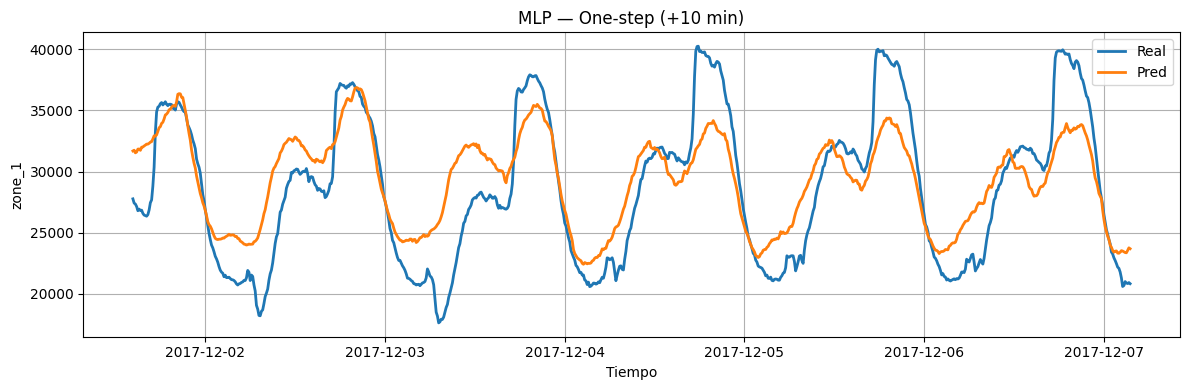

In [ ]:
# =========================
# PRONÓSTICO A 1 PASO — One-step (+10 min)
# =========================
# Fundamento:
# - Cada fila de Xva2/Xte2 representa la ventana aplanada (1008 * F) que termina en t.
# - El MLP predice y_hat(t+1) en escala normalizada (mismo setup que ensambles).
# - No hay retroalimentación de predicciones aquí (no es necesario en one-step).

# Predicciones (escala normalizada)
y_pred_val_mlp = mlp.predict(Xva2, batch_size=4096, verbose=0).reshape(-1)
y_pred_te_mlp  = mlp.predict(Xte2, batch_size=4096, verbose=0).reshape(-1)

# Invertir a escala real para métricas interpretables (WAPE/sMAPE)
y_val_inv_mlp      = inverse_target(yva, scalers)
y_pred_val_inv_mlp = inverse_target(y_pred_val_mlp, scalers)
y_te_inv_mlp       = inverse_target(yte, scalers)
y_pred_te_inv_mlp  = inverse_target(y_pred_te_mlp, scalers)

# (Opcional) Tramo temporal para graficar en TEST
start = HISTORY_WINDOW + SHIFT_ONE_STEP - 1
idx_seg = test_df.index[start : start + len(y_te_inv_mlp)]

plot_segment(
    idx_seg[:800], y_te_inv_mlp[:800], y_pred_te_inv_mlp[:800],
    title="MLP — One-step (+10 min)", target_name=TARGET_COL
)

La gráfica de one‑step muestra que el modelo tiene dificultades para seguir los patrones de alta frecuencia: suaviza demasiado la serie, subestima los picos de consumo y sobreestima los valles, lo cual se traduce en un error elevado en el corto plazo (TEST one‑step: sMAPE 8.914% y WAPE 9.009%)

A múltiples pasos

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


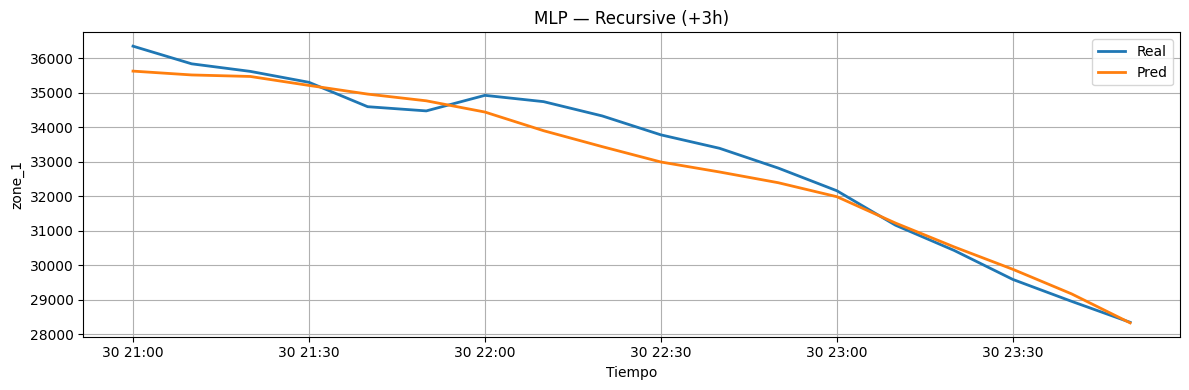

In [ ]:
# ==============================================
# PRONÓSTICO A MÚLTIPLES PASOS — Recursive (+3h)
# ==============================================
# Fundamento:
# - Autoregresivo: se usa la salida de t+1 como lag para predecir t+2, etc.
# - Exógenas: estrategia "hold" (se mantienen fijas) salvo que se provea exog_future.
# - Esta estrategia tiende a acumular error con el horizonte (propagación), como se observa en boosting.

def recursive_forecast(
    model,
    seed_window: np.ndarray,   # (HISTORY_WINDOW, F) en escala normalizada
    steps: int,
) -> np.ndarray:
    """
    Genera 'steps' predicciones autoregresivas.
    Se asume que la ÚLTIMA columna de seed_window es el TARGET
    (orden de features: EXOG_COLS + [TARGET_COL]).
    """
    hist = seed_window.copy()      # (H, F)
    preds = []
    for _ in range(steps):
        x = hist.reshape(1, -1)    # aplanar para modelos tabulares (sklearn)
        y_hat = model.predict(x)[0]  # escala normalizada
        preds.append(y_hat)

        # Exógenas: estrategia 'hold' (mantener último valor); actualizar TARGET con y_hat
        next_row = hist[-1].copy()
        next_row[-1] = y_hat
        hist = np.vstack([hist[1:], next_row])
    return np.array(preds)

STEPS = 18  # 3 horas (18 * 10 min)
feats_order = EXOG_COLS + [TARGET_COL]

# Semilla al final de test dejando espacio para 'STEPS' futuros
seed_start = max(0, len(test_n) - (HISTORY_WINDOW + STEPS))
seed_end   = seed_start + HISTORY_WINDOW
seed_win   = test_n[feats_order].values[seed_start:seed_end]  # normalizado, target última col

# Reutilizamos tu función genérica (aplana y llama .predict()), adecuada para MLP
y_pred_rec_norm_mlp = recursive_forecast(mlp, seed_win, STEPS)
y_pred_rec_mlp      = inverse_target(y_pred_rec_norm_mlp, scalers)

# Verdaderos y tiempos para evaluación homogénea
true_start = seed_end
true_end   = seed_end + STEPS
y_true_rec = test_df[TARGET_COL].values[true_start:true_end]
idx_future = test_df.index[true_start:true_end]

plot_segment(
    idx_future, y_true_rec, y_pred_rec_mlp,
    title="MLP — Recursive (+3h)", target_name=TARGET_COL
)


En el escenario recursivo a 3 horas la predicción se ajusta mucho mejor a la tendencia descendente y casi se solapa con la curva real, alcanzando métricas sorprendentemente bajas (sMAPE 1.141% y WAPE 1.158%), un resultado que sorprende al estar hablando de un método recursivo.

---

#### **Evaluación**

In [ ]:
# =========================
# EVALUACIÓN — sMAPE / WAPE
# =========================
# Consideraciones:
# - Calculamos en ESCALA REAL (post-inversión) para interpretación de negocio.
# - Reportamos one-step (val/test) y recursive (test).

# One-step
smape_val_mlp = smape(y_val_inv_mlp, y_pred_val_inv_mlp)
wape_val_mlp  = wape(y_val_inv_mlp, y_pred_val_inv_mlp)
smape_te_mlp  = smape(y_te_inv_mlp,  y_pred_te_inv_mlp)
wape_te_mlp   = wape(y_te_inv_mlp,   y_pred_te_inv_mlp)

print(f"[MLP] ONE-STEP → VAL  sMAPE: {smape_val_mlp:.3f}% | WAPE: {wape_val_mlp:.3f}%")
print(f"[MLP] ONE-STEP → TEST sMAPE: {smape_te_mlp:.3f}% | WAPE: {wape_te_mlp:.3f}%")

# Recursive (+3h)
smape_rec_mlp = smape(y_true_rec, y_pred_rec_mlp)
wape_rec_mlp  = wape(y_true_rec, y_pred_rec_mlp)
print(f"[MLP] RECURSIVE (3h) → TEST sMAPE: {smape_rec_mlp:.3f}% | WAPE: {wape_rec_mlp:.3f}%")
print(f"[MLP] Training time: {training_time:.2f}s")

[MLP] ONE-STEP → VAL  sMAPE: 7.043% | WAPE: 6.788%
[MLP] ONE-STEP → TEST sMAPE: 8.914% | WAPE: 9.009%
[MLP] RECURSIVE (3h) → TEST sMAPE: 1.141% | WAPE: 1.158%
[MLP] Training time: 24.19s


---

El MLP presentó un tiempo de entrenamiento de 24.19 segundos, con un desempeño muy desigual según el horizonte de predicción. En el escenario one‑step (10 min) sus métricas fueron bastante pobres (sMAPE 8.914% y WAPE 9.009%), evidenciando que el modelo tiende a suavizar las oscilaciones de la serie y no logra capturar con precisión los picos de consumo energético, lo cual lo hace poco confiable para predicciones inmediatas. Sin embargo, de manera sorprendente, en el horizonte recursivo a 3h el MLP redujo drásticamente el error (sMAPE 1.141% y WAPE 1.158%), mostrando un ajuste muy bueno a la tendencia general del consumo en ese tramo.

#### Referencias:
MLP (Perceptrón Multicapa):
- Rumelhart, Hinton & Williams (1986), *Backpropagation* (fundamento del entrenamiento). ([Stanford University](https://stanford.edu/~jlmcc/papers/PDP/Volume%201/Chap8_PDP86.pdf))